
... ***CURRENTLY UNDER DEVELOPMENT*** ...


## HyCReWW runup estimation 

inputs required: 
  * Nearshore reconstructed historical hourly runup (for plotting)
  * Nearshore reconstructed simulated hourly waves
  * Synthetic water levels 
  * Projected Sea Level Rise at the Site (for 3 scenarios: intermediate low, intermediate, intermediate high)

in this notebook:
  * HyCReWW runup estimation of synthetic events **taking into account 3 SLR scenarios**
  * Extreme value analysis comparison

In [4]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import pandas as pd
import xarray as xr
from scipy.interpolate import griddata

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..', '..'))

# teslakit
from teslakit.database import Database, SplitStorage
from teslakit.rbf import RBF_Interpolation, RBF_Reconstruction
from teslakit.mda import Normalize, MaxDiss_Simplified_NoThreshold, nearest_indexes

from teslakit.plotting.extremes import Plot_ReturnPeriodValidation_CC



## Database and Site parameters

In [3]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/albacid/Projects/TeslaKit_projects'
db = Database(p_data)

# set site
db.SetSite('ROI')

# climate change - S1
db_S1 = Database(p_data)
db_S1.SetSite('ROI_CC_S1')

# climate change - S2
db_S2 = Database(p_data)
db_S2.SetSite('ROI_CC_S2')

# climate change - S3
db_S3 = Database(p_data)
db_S3.SetSite('ROI_CC_S3')



## HyCReWW - RBFs configuration

runup has been calculated for a total of 15 scenarios (hs, hs_lo) and a set of reef characteristics 

In [3]:
# 15 scenarios of runup model execution

# RBF wave conditions 
rbf_hs = [1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5]
rbf_hs_lo = [0.005, 0.025, 0.05, 0.005, 0.025, 0.05, 0.005, 0.025, 0.05, 0.005, 0.025, 0.05, 0.005, 0.025, 0.05]

# load trained RBF coefficients and variables min. and max. limits
var_lims, rbf_coeffs = db.Load_HYCREWW()

# reef characteristics
reef_cs = {
    'rslope': 0.0505,
    'bslope': 0.1667,
    'rwidth': 250,
    'cf': 0.0105,
}

# rbf variables names: level is our teslakit input data
rbf_vns = ['level', 'rslope', 'bslope', 'rwidth', 'cf']

## HyCReWW methodology library

In [4]:
def HyCReWW_RU(df):
    '''
    Calculates runup using HyCReWW RBFs (level, reef variables) 
    and a linear interpolation (hs, hs_lo2) to input dataset
    
    var_lims   - HyCReWW variables min and max limits
    rbf_coeffs - HyCReWW rbf coefficients
    reef_cs    - reef characteristics
    rbf_vns    - rbf variables

    df         - input pandas.dataframe (time,), vars: level, hs, tp, dir, hs_lo2
    '''
    
    
    # 1. Prepare input data
    # -----------------------------------------------------------------
    
    # add reef characteristics to input dataset
    for p in reef_cs.keys(): df[p] = reef_cs[p]
        
    # filter data: all variables inside limits
    lp = []
    for vn in var_lims.keys():
        ps = (df[vn] > var_lims[vn][0]) & (df[vn] < var_lims[vn][1])
        lp.append(ps)
    ix_in = np.where(np.all(lp, axis=0))[0]
        
    # select dataset to interpolate at RBFs
    ds_in = df.iloc[ix_in]
    ds_rbf_in = ds_in[rbf_vns]
    
    
    
    # 2. Calculate RUNUP with input LEVEL for the 15 RBF scenarios
    # -----------------------------------------------------------------   
    
    # parameters
    ix_sc = [0, 1, 2, 3, 4]
    ix_dr = []
    minis = [var_lims[x][0] for x in rbf_vns]
    maxis = [var_lims[x][1] for x in rbf_vns]

    # Normalize data
    ds_nm ,_ ,_ = Normalize(ds_rbf_in.values, ix_sc, ix_dr, minis=minis, maxis=maxis)

    # RBF interpolate level for the 15 scenarios
    aux_1 = []
    for rc in rbf_coeffs:
        ro = RBF_Interpolation(rc['constant'], rc['coeff'], rc['nodes'], ds_nm.T)
        aux_1.append(ro)
    ru_z = np.array(aux_1)

    
    
    # 3. interpolate RUNUP for input WAVES with the 15 RBF scenarios
    # -----------------------------------------------------------------   
     
    # RU linear interpolation (15 sets: hs, hs_lo -> runup)
    #ru_in = np.zeros(ds_in.shape[0]) * np.nan
    #for c, (_, r) in enumerate(ds_in.iterrows()):
    #    ru_in[c] = griddata((rbf_hs, rbf_hs_lo), ru_z[:,c], (r['hs'], r['hs_lo2']), method='linear')
    
    # RU linear interpolation (15 sets: hs, hs_lo -> runup)  (*faster than loop)
    def axis_ipl_rbfs(inp):
        return griddata((rbf_hs, rbf_hs_lo), inp[:15], (inp[15], inp[16]), method='linear')

    inp = np.concatenate((ru_z, ds_in[['hs', 'hs_lo2']].T))      
    ru_in = np.apply_along_axis(axis_ipl_rbfs, 0, inp)
    
    
    
    # 4. Prepare output 
    # -----------------------------------------------------------------
    
    # add level to run_up
    ru_in = ru_in + ds_in['level']
    
    # return runup 
    ru_out = np.zeros(len(df.index)) * np.nan
    ru_out[ix_in] = ru_in
    
    xds_ru = xr.Dataset({'runup': (('time',), ru_out)}, coords={'time': df.index})

    return xds_ru


## HyCReWW MDA-RBF statistical wrap

In [5]:
def mdarbf_HyCReWW(dataset):
    '''
    Solves HyCReWW methodology using a MDA-RBFs statistical wrap. 
    This results in a substantial reduce in computational cost.
    
    A Statistical representative subset will be selected with MaxDiss algorithm from input dataset.
    This subset will be solved using HyCReWW methodology.
    This subset and its runup HyCReWW output will be used to fit Radial Basis Functions.
    
    Using RBFs, the entire input dataset is statistically solved
    '''

    base_dataset = dataset.copy()
    
    # 1. MaxDiss 
    # -----------------------------------------------------------------

    vns_mda = ['hs', 'hs_lo2','level']  # variables used at classification
    n_subset = 100
    ix_scalar = [0, 1, 2]
    ix_directional = []
    
    # remove nan data from input dataset
    dataset.dropna(inplace=True)
 
    # data for MDA
    data = dataset[vns_mda]
    
    # MDA algorithm
    sel = MaxDiss_Simplified_NoThreshold(data.values[:], n_subset, ix_scalar, ix_directional)
    subset = pd.DataFrame(data=sel, columns=vns_mda)

    # fill subset variables
    ix_n = nearest_indexes(subset[vns_mda].values[:], data.values[:], ix_scalar, ix_directional)
    vns_fill = ['tp', 'dir']
    for vn in vns_fill:
        subset[vn] = dataset[vn].iloc[ix_n].values[:]
        
    # calculate runup with HyCReWW
    ru_sel = HyCReWW_RU(subset)
    target = ru_sel.runup.to_dataframe()
    
    # clean subset variables
    subset.drop(columns=['rslope', 'bslope', 'rwidth', 'cf'], inplace=True)
    
    # clean nans from runup target and input subset
    ix_rm = np.where(np.isnan(target.values))[0]
    subset.drop(index=ix_rm, inplace=True)
    target.drop(index=ix_rm, inplace=True)

    
    # 2. RBF RunUp Reconstruction
    # -----------------------------------------------------------------
    vs_recon = ['hs', 'hs_lo2','level'] 
    subset_r = subset[vs_recon]
    dataset_r = base_dataset[vs_recon]  # to maintain input indexes and put nan where there is no output
    
    ix_scalar_subset = [0, 1, 2]
    ix_scalar_target = [0]
    
    recon = RBF_Reconstruction(
        subset_r.values, ix_scalar_subset, [],
        target.values, ix_scalar_target, [],
        dataset_r.values
    )
    
    xds_ru = xr.Dataset({'runup': (('time',), recon.squeeze())}, coords={'time': base_dataset.index})
    
    return xds_ru


## HyCReWW RBF Interpolation Simulation data

In [6]:
# offshore level 
level = db.Load_SIM_OFFSHORE_all(vns=['level'], decode_times=False)

# nearshore waves
waves = db.Load_SIM_NEARSHORE_all(vns=['Hs', 'Tp', 'Dir'], decode_times=False)

# prepare data for hycreww
waves = waves.rename_vars({"Hs": "hs", "Tp": "tp", 'Dir':'dir'})  # rename vars
waves['hs_lo2'] = waves['hs']/(1.5613*waves['tp']**2)             # calc. hs_lo2
waves['level'] = level['level']                                   # add level

# fix simulation times (cftimes)
tmpt = db.Load_SIM_NEARSHORE_all(vns=['Hs'], decode_times=True, use_cftime=True)
waves['time'] = tmpt['time']



## Sea Level Rise Scenarios

In [7]:
# Load SLR file

SLR = db.Load_SeaLevelRise()
SLR['time'] = SLR.time.dt.round('H')

# use available SLR dates
waves_t = waves.isel(time=slice(0, len(SLR.time)))



## Hycreww RBF Interpolation: Simulation

In [10]:
# solve all SLR scenarios
save_db = [db_S1, db_S2, db_S3]

for c, sc in enumerate(SLR.scenario):
    slr_sc = SLR.sel(scenario=sc)
    
    # copy waves data
    waves_r = waves_t.copy(deep=True)
    
    # iterate  simulations
    for n in waves_r.n_sim:
        waves_n = waves_r.sel(n_sim=int(n))
        
        # increase level with SLR
        waves_n['level'] = (('time',), waves_n['level'].values + slr_sc['SLR'].values)
    
        dataset = waves_n[['hs', 'tp', 'dir', 'level', 'hs_lo2']].to_dataframe()

        # calculate runup with HyCReWW
        #ru_sim_n = HyCREWW_RU(dataset)
    
        # calculate runup with HyCReWW MDA-RBF wrap
        ru_sim_n = mdarbf_HyCReWW(dataset)
    
        # store simulation runup    
        save_db[c].Save_SIM_NEARSHORE(ru_sim_n, int(n))
    
        print('simulation {0} processed.'.format(int(n)))
    
    
    print('SLR scenario {0} complete.\n'.format(int(c+1)))



MaxDiss dataset: 885360 --> 100

   MDA centroids: 100/100

ix_scalar: 0,  optimization: 0.11 | interpolation: 35.79
simulation 0 processed.

MaxDiss dataset: 885336 --> 100

   MDA centroids: 100/100

ix_scalar: 0,  optimization: 0.18 | interpolation: 36.92
simulation 1 processed.

MaxDiss dataset: 885360 --> 100

   MDA centroids: 100/100

ix_scalar: 0,  optimization: 0.17 | interpolation: 36.15
simulation 2 processed.

MaxDiss dataset: 885360 --> 100

   MDA centroids: 100/100

ix_scalar: 0,  optimization: 0.15 | interpolation: 36.68
simulation 3 processed.

MaxDiss dataset: 885360 --> 100

   MDA centroids: 100/100

ix_scalar: 0,  optimization: 0.22 | interpolation: 36.27
simulation 4 processed.

MaxDiss dataset: 885360 --> 100

   MDA centroids: 100/100

ix_scalar: 0,  optimization: 0.18 | interpolation: 36.09
simulation 5 processed.

MaxDiss dataset: 885360 --> 100

   MDA centroids: 100/100

ix_scalar: 0,  optimization: 0.21 | interpolation: 36.52
simulation 6 processed.

MaxDi


## Methodology Validation: Annual Maxima

In [5]:
# Load historical and simulated runup
hist_ru = db.Load_HIST_NEARSHORE(vns=['runup'], decode_times=True)
ru_sims = db.Load_SIM_NEARSHORE_all(vns=['runup'], decode_times=True, use_cftime=True)

ru_sims_CChange_S1 = db_S1.Load_SIM_NEARSHORE_all(vns=['runup'], decode_times=True, use_cftime=True)
ru_sims_CChange_S2 = db_S2.Load_SIM_NEARSHORE_all(vns=['runup'], decode_times=True, use_cftime=True)
ru_sims_CChange_S3 = db_S3.Load_SIM_NEARSHORE_all(vns=['runup'], decode_times=True, use_cftime=True)



In [7]:
# Keep first 100 years of simulation without climate change
ru_sims = ru_sims.isel(time=slice(0, len(ru_sims_CChange_S1.time))) # 100 years


In [8]:
# compare historical and simulations runup annual maxima
hist_A = hist_ru['runup'].groupby('time.year').max(dim='time')
sim_A = ru_sims['runup'].groupby('time.year').max(dim='time')

### SLR S1 (intermediate low, +0.5m)

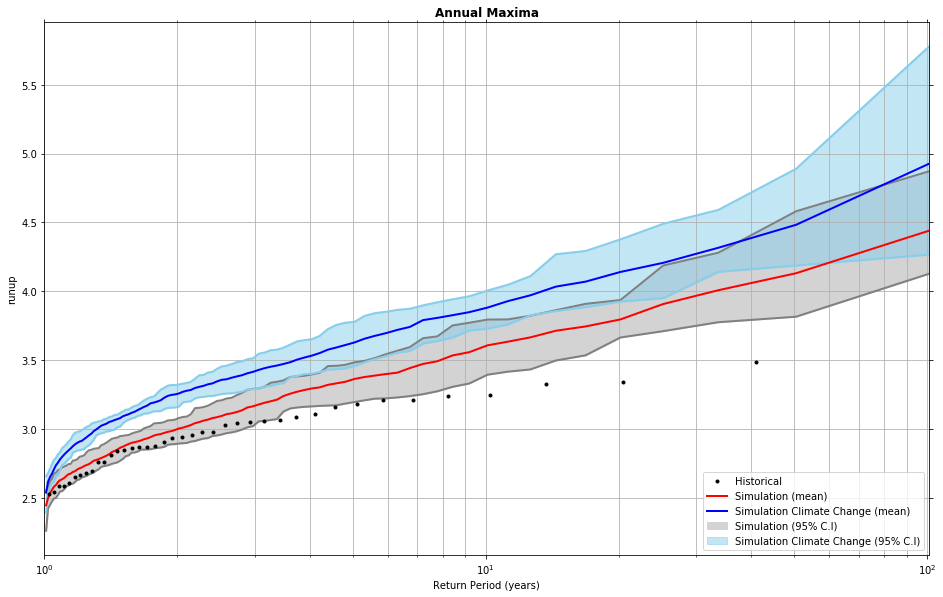

In [9]:
sim_B = ru_sims_CChange_S1['runup'].groupby('time.year').max(dim='time')

# Return Period historical vs. simulations
Plot_ReturnPeriodValidation_CC(hist_A, sim_A.transpose(), sim_B.transpose());


### SLR S2 (intermediate, +1m)

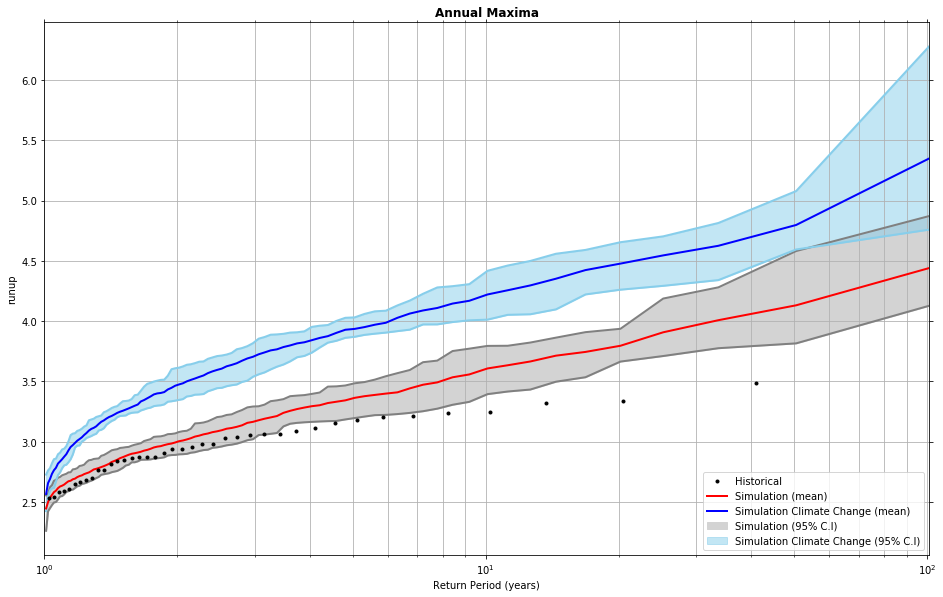

In [10]:
sim_B = ru_sims_CChange_S2['runup'].groupby('time.year').max(dim='time')

# Return Period historical vs. simulations
Plot_ReturnPeriodValidation_CC(hist_A, sim_A.transpose(), sim_B.transpose());


### SLR S3 (intermediate high, +1.5m)


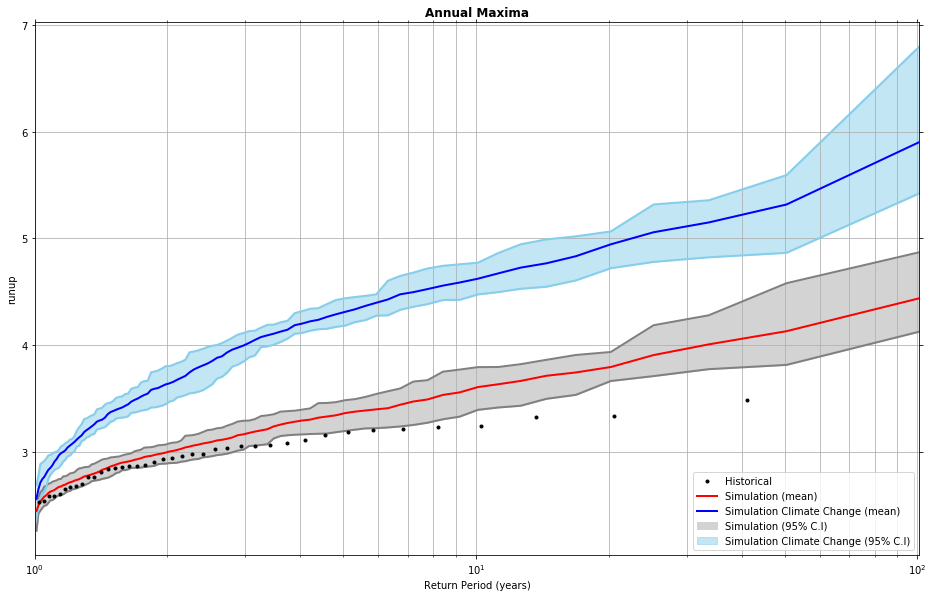

In [11]:
sim_B = ru_sims_CChange_S3['runup'].groupby('time.year').max(dim='time')

# Return Period historical vs. simulations
Plot_ReturnPeriodValidation_CC(hist_A, sim_A.transpose(), sim_B.transpose());
